# ResNet Implementation in Pytorch

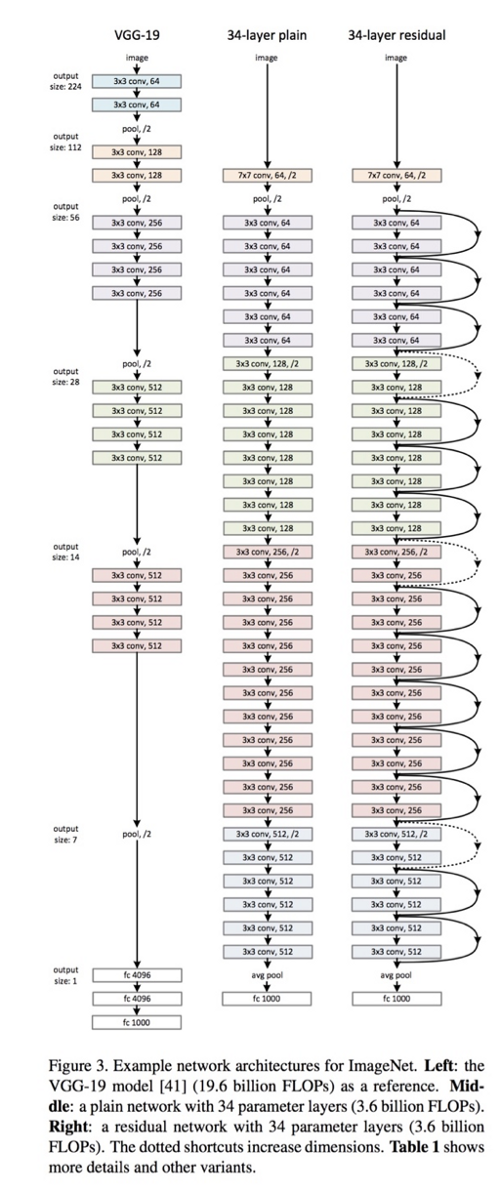

In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.datasets as datasets

In [3]:
class block(nn.Module):
  def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
    super(block,self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels,out_channels*self.expansion,kernel_size=1,stride=1,padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
  
  def forward(self,x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    
    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    
    x+=identity
    x = self.relu(x)
    return x

class ResNet(nn.Module):
  def __init__(self,block,layers,image_channels,num_classes):
    super(ResNet,self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.layer1 = self._make_layer(block,layers[0],out_channels=64,stride=1)
    self.layer2 = self._make_layer(block,layers[1],out_channels=128,stride=2)
    self.layer3 = self._make_layer(block,layers[2],out_channels=256,stride=2)
    self.layer4 = self._make_layer(block,layers[3],out_channels=512,stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4,num_classes)
  
  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc(x)
    return x 

  def _make_layer(self,block,num_residual_blocks,out_channels,stride):
    identity_downsample = None 
    layers = [] 
    if stride!=1 or self.in_channels!=out_channels*4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,
                                                    out_channels*4,kernel_size=1,stride=stride),
                                          nn.BatchNorm2d(out_channels*4))
    layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks-1):
      layers.append(block(self.in_channels,out_channels))
    
    return nn.Sequential(*layers)

def ResNet50(img_channels=3,num_classes=1000):
  return ResNet(block,[3,4,6,3],img_channels,num_classes)

def ResNet101(img_channels=3,num_classes=1000):
  return ResNet(block,[3,4,23,3],img_channels,num_classes)

def ResNet152(img_channels=3,num_classes=1000):
  return ResNet(block,[3,8,36,3],img_channels,num_classes)

def test():
  net = ResNet50(img_channels=3,num_classes =1000)
  x = torch.randn(2,3,224,224)
  y = net(x).to('cuda')
  print(y.shape)

test()


torch.Size([2, 1000])
